In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13154031514498188062, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15870695997489903410
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import sys
import time
import math
import os
import pandas as pd
import numpy as np

import keras
from keras import layers, metrics, models, optimizers
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, concatenate, Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0


In [5]:
batch_size = 16
img_rows, img_cols = 256, 256
input_shape = (img_rows, img_cols, 3)
epochs = 150

In [6]:
train_dir = 'data_augmented/cvc300_train/'
validation_dir = 'data_augmented/cvc300_validation/'
test_dir = 'data_augmented/cvc300_test/'

image_folder = 'images'
masks_folder = 'masks'

In [7]:
import numpy as np 
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(pretrained_weights = None,input_size = (img_rows, img_cols,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    return model

In [8]:
seed = 1142
data_gen_args = dict(rescale=1. / 255, featurewise_center=True, featurewise_std_normalization=True)
image_datagen = ImageDataGenerator(**data_gen_args)
masks_datagen = ImageDataGenerator(**data_gen_args)

test_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    train_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

mask_generator = masks_datagen.flow_from_directory(
    train_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_image_generator = image_datagen.flow_from_directory(
    validation_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_mask_generator = masks_datagen.flow_from_directory(
    validation_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_image_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_mask_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

Found 26112 images belonging to 1 classes.
Found 26112 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [9]:
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

In [10]:
nb_train_samples = len(image_generator.filenames)
nb_validation_samples = len(validation_image_generator.filenames)
nb_test_samples = len(test_image_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

nb_train_samples: 26112
nb_validation_samples: 8704
nb_test_samples: 28

predict_size_train: 1632
predict_size_validation: 544
predict_size_test: 2


In [11]:
smooth = 1.
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [12]:
model = unet()
model.summary()
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss=dice_coef_loss, 
              metrics=[dice_coef, 'acc','mse', Jaccard_index, Specificity, Sensitivity, precision, recall, f1score])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [13]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples//batch_size)

Epoch 1/150
1632/1632 [==============================] - 997s 611ms/step - loss: -0.0939 - dice_coef: 0.0939 - acc: 0.5685 - mean_squared_error: 0.1774 - Jaccard_index: 0.0501 - Specificity: 0.9632 - Sensitivity: 1.2179 - precision: 0.0305 - recall: 0.2505 - f1score: nan - val_loss: -0.1615 - val_dice_coef: 0.1615 - val_acc: 0.5893 - val_mean_squared_error: 0.0942 - val_Jaccard_index: 0.0883 - val_Specificity: 0.9548 - val_Sensitivity: 1.1193 - val_precision: 0.0360 - val_recall: 0.1777 - val_f1score: nan
Epoch 2/150
1632/1632 [==============================] - 990s 607ms/step - loss: -0.1744 - dice_coef: 0.1744 - acc: 0.6937 - mean_squared_error: 0.0649 - Jaccard_index: 0.0967 - Specificity: 0.9614 - Sensitivity: 1.0644 - precision: 0.0499 - recall: 0.1587 - f1score: nan - val_loss: -0.2852 - val_dice_coef: 0.2852 - val_acc: 0.7694 - val_mean_squared_error: 0.0449 - val_Jaccard_index: 0.1669 - val_Specificity: 0.9539 - val_Sensitivity: 1.0164 - val_precision: 0.1218 - val_recall: 0.19

Epoch 17/150
1632/1632 [==============================] - 983s 603ms/step - loss: -0.8898 - dice_coef: 0.8898 - acc: 0.8389 - mean_squared_error: 0.0047 - Jaccard_index: 0.8025 - Specificity: 0.9752 - Sensitivity: 1.0030 - precision: 0.9685 - recall: 0.9564 - f1score: 0.9623 - val_loss: -0.8014 - val_dice_coef: 0.8014 - val_acc: 0.8295 - val_mean_squared_error: 0.0145 - val_Jaccard_index: 0.6731 - val_Specificity: 0.9650 - val_Sensitivity: 0.9983 - val_precision: 0.9482 - val_recall: 0.7955 - val_f1score: 0.8613
Epoch 18/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.8913 - dice_coef: 0.8913 - acc: 0.8390 - mean_squared_error: 0.0046 - Jaccard_index: 0.8049 - Specificity: 0.9752 - Sensitivity: 1.0029 - precision: 0.9698 - recall: 0.9584 - f1score: 0.9640 - val_loss: -0.7911 - val_dice_coef: 0.7911 - val_acc: 0.8289 - val_mean_squared_error: 0.0155 - val_Jaccard_index: 0.6596 - val_Specificity: 0.9646 - val_Sensitivity: 0.9982 - val_precision: 0.9409 - val_r

Epoch 33/150
1632/1632 [==============================] - 981s 601ms/step - loss: -0.9019 - dice_coef: 0.9019 - acc: 0.8395 - mean_squared_error: 0.0037 - Jaccard_index: 0.8222 - Specificity: 0.9755 - Sensitivity: 1.0028 - precision: 0.9803 - recall: 0.9712 - f1score: 0.9757 - val_loss: -0.7980 - val_dice_coef: 0.7980 - val_acc: 0.8292 - val_mean_squared_error: 0.0150 - val_Jaccard_index: 0.6686 - val_Specificity: 0.9649 - val_Sensitivity: 0.9985 - val_precision: 0.9435 - val_recall: 0.7946 - val_f1score: 0.8587
Epoch 34/150
1632/1632 [==============================] - 981s 601ms/step - loss: -0.9022 - dice_coef: 0.9022 - acc: 0.8396 - mean_squared_error: 0.0036 - Jaccard_index: 0.8228 - Specificity: 0.9755 - Sensitivity: 1.0028 - precision: 0.9807 - recall: 0.9716 - f1score: 0.9761 - val_loss: -0.7989 - val_dice_coef: 0.7989 - val_acc: 0.8292 - val_mean_squared_error: 0.0150 - val_Jaccard_index: 0.6703 - val_Specificity: 0.9649 - val_Sensitivity: 0.9986 - val_precision: 0.9421 - val_r

Epoch 49/150
1632/1632 [==============================] - 984s 603ms/step - loss: -0.9059 - dice_coef: 0.9059 - acc: 0.8398 - mean_squared_error: 0.0033 - Jaccard_index: 0.8290 - Specificity: 0.9756 - Sensitivity: 1.0027 - precision: 0.9847 - recall: 0.9762 - f1score: 0.9804 - val_loss: -0.7971 - val_dice_coef: 0.7971 - val_acc: 0.8292 - val_mean_squared_error: 0.0152 - val_Jaccard_index: 0.6677 - val_Specificity: 0.9646 - val_Sensitivity: 0.9979 - val_precision: 0.9479 - val_recall: 0.7895 - val_f1score: 0.8568
Epoch 50/150
1632/1632 [==============================] - 984s 603ms/step - loss: -0.9060 - dice_coef: 0.9060 - acc: 0.8398 - mean_squared_error: 0.0033 - Jaccard_index: 0.8291 - Specificity: 0.9756 - Sensitivity: 1.0027 - precision: 0.9850 - recall: 0.9764 - f1score: 0.9806 - val_loss: -0.8014 - val_dice_coef: 0.8014 - val_acc: 0.8291 - val_mean_squared_error: 0.0149 - val_Jaccard_index: 0.6731 - val_Specificity: 0.9652 - val_Sensitivity: 0.9994 - val_precision: 0.9368 - val_r

Epoch 65/150
1632/1632 [==============================] - 984s 603ms/step - loss: -0.9084 - dice_coef: 0.9084 - acc: 0.8399 - mean_squared_error: 0.0031 - Jaccard_index: 0.8331 - Specificity: 0.9756 - Sensitivity: 1.0026 - precision: 0.9872 - recall: 0.9789 - f1score: 0.9830 - val_loss: -0.7958 - val_dice_coef: 0.7958 - val_acc: 0.8291 - val_mean_squared_error: 0.0153 - val_Jaccard_index: 0.6658 - val_Specificity: 0.9648 - val_Sensitivity: 0.9985 - val_precision: 0.9418 - val_recall: 0.7920 - val_f1score: 0.8560
Epoch 66/150
1632/1632 [==============================] - 984s 603ms/step - loss: -0.9085 - dice_coef: 0.9085 - acc: 0.8399 - mean_squared_error: 0.0031 - Jaccard_index: 0.8332 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9873 - recall: 0.9791 - f1score: 0.9832 - val_loss: -0.7895 - val_dice_coef: 0.7895 - val_acc: 0.8291 - val_mean_squared_error: 0.0157 - val_Jaccard_index: 0.6574 - val_Specificity: 0.9644 - val_Sensitivity: 0.9977 - val_precision: 0.9470 - val_r

Epoch 81/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.9098 - dice_coef: 0.9098 - acc: 0.8400 - mean_squared_error: 0.0029 - Jaccard_index: 0.8354 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9888 - recall: 0.9808 - f1score: 0.9847 - val_loss: -0.7957 - val_dice_coef: 0.7957 - val_acc: 0.8291 - val_mean_squared_error: 0.0153 - val_Jaccard_index: 0.6648 - val_Specificity: 0.9648 - val_Sensitivity: 0.9985 - val_precision: 0.9435 - val_recall: 0.7912 - val_f1score: 0.8570
Epoch 82/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.9099 - dice_coef: 0.9099 - acc: 0.8400 - mean_squared_error: 0.0029 - Jaccard_index: 0.8356 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9889 - recall: 0.9807 - f1score: 0.9848 - val_loss: -0.8003 - val_dice_coef: 0.8003 - val_acc: 0.8291 - val_mean_squared_error: 0.0150 - val_Jaccard_index: 0.6716 - val_Specificity: 0.9651 - val_Sensitivity: 0.9992 - val_precision: 0.9380 - val_r

Epoch 97/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.9108 - dice_coef: 0.9108 - acc: 0.8400 - mean_squared_error: 0.0028 - Jaccard_index: 0.8373 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9899 - recall: 0.9819 - f1score: 0.9858 - val_loss: -0.7902 - val_dice_coef: 0.7902 - val_acc: 0.8290 - val_mean_squared_error: 0.0157 - val_Jaccard_index: 0.6581 - val_Specificity: 0.9645 - val_Sensitivity: 0.9979 - val_precision: 0.9453 - val_recall: 0.7816 - val_f1score: 0.8511
Epoch 98/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.9108 - dice_coef: 0.9108 - acc: 0.8400 - mean_squared_error: 0.0028 - Jaccard_index: 0.8371 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9900 - recall: 0.9820 - f1score: 0.9859 - val_loss: -0.7908 - val_dice_coef: 0.7908 - val_acc: 0.8290 - val_mean_squared_error: 0.0157 - val_Jaccard_index: 0.6587 - val_Specificity: 0.9644 - val_Sensitivity: 0.9979 - val_precision: 0.9458 - val_r

Epoch 113/150
1632/1632 [==============================] - 982s 602ms/step - loss: -0.9116 - dice_coef: 0.9116 - acc: 0.8400 - mean_squared_error: 0.0028 - Jaccard_index: 0.8385 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9907 - recall: 0.9829 - f1score: 0.9868 - val_loss: -0.7893 - val_dice_coef: 0.7893 - val_acc: 0.8290 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6570 - val_Specificity: 0.9643 - val_Sensitivity: 0.9978 - val_precision: 0.9455 - val_recall: 0.7784 - val_f1score: 0.8492
Epoch 114/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.9118 - dice_coef: 0.9118 - acc: 0.8401 - mean_squared_error: 0.0028 - Jaccard_index: 0.8388 - Specificity: 0.9757 - Sensitivity: 1.0026 - precision: 0.9909 - recall: 0.9830 - f1score: 0.9869 - val_loss: -0.7879 - val_dice_coef: 0.7879 - val_acc: 0.8290 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6554 - val_Specificity: 0.9643 - val_Sensitivity: 0.9977 - val_precision: 0.9461 - val

Epoch 129/150
1632/1632 [==============================] - 982s 602ms/step - loss: -0.9124 - dice_coef: 0.9124 - acc: 0.8401 - mean_squared_error: 0.0027 - Jaccard_index: 0.8398 - Specificity: 0.9758 - Sensitivity: 1.0026 - precision: 0.9914 - recall: 0.9838 - f1score: 0.9876 - val_loss: -0.7875 - val_dice_coef: 0.7875 - val_acc: 0.8290 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6544 - val_Specificity: 0.9643 - val_Sensitivity: 0.9977 - val_precision: 0.9461 - val_recall: 0.7746 - val_f1score: 0.8476
Epoch 130/150
1632/1632 [==============================] - 983s 602ms/step - loss: -0.9123 - dice_coef: 0.9123 - acc: 0.8401 - mean_squared_error: 0.0027 - Jaccard_index: 0.8397 - Specificity: 0.9758 - Sensitivity: 1.0026 - precision: 0.9915 - recall: 0.9838 - f1score: 0.9876 - val_loss: -0.7888 - val_dice_coef: 0.7888 - val_acc: 0.8289 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6563 - val_Specificity: 0.9644 - val_Sensitivity: 0.9979 - val_precision: 0.9436 - val

Epoch 145/150
1632/1632 [==============================] - 982s 602ms/step - loss: -0.9129 - dice_coef: 0.9129 - acc: 0.8401 - mean_squared_error: 0.0027 - Jaccard_index: 0.8408 - Specificity: 0.9758 - Sensitivity: 1.0025 - precision: 0.9920 - recall: 0.9844 - f1score: 0.9882 - val_loss: -0.7880 - val_dice_coef: 0.7880 - val_acc: 0.8289 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6554 - val_Specificity: 0.9644 - val_Sensitivity: 0.9978 - val_precision: 0.9443 - val_recall: 0.7778 - val_f1score: 0.8482
Epoch 146/150
1632/1632 [==============================] - 982s 602ms/step - loss: -0.9127 - dice_coef: 0.9127 - acc: 0.8401 - mean_squared_error: 0.0027 - Jaccard_index: 0.8403 - Specificity: 0.9758 - Sensitivity: 1.0025 - precision: 0.9920 - recall: 0.9843 - f1score: 0.9881 - val_loss: -0.7951 - val_dice_coef: 0.7951 - val_acc: 0.8291 - val_mean_squared_error: 0.0153 - val_Jaccard_index: 0.6640 - val_Specificity: 0.9648 - val_Sensitivity: 0.9984 - val_precision: 0.9436 - val

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  -0.7890231275558471
Validation Accuracy:  0.7890231275558471


In [15]:
prediction = model.predict_generator(test_generator, verbose=1, steps=nb_test_samples)

28/28 [==============================] - 6s 201ms/step


In [16]:
prediction.shape

(392, 256, 256, 1)

In [17]:
test_results = model.evaluate_generator(test_generator, steps=50)

print(model.metrics_names)
print(test_results)

['loss', 'dice_coef', 'acc', 'mean_squared_error', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score']
[-0.847023127419608, 0.8470231294631958, 0.9857708532469613, 0.01419655657772507, 0.7391278535979134, 0.9694751994950431, 0.9973936946051462, 0.9272227348600115, 0.7857990510123116, 0.8469940744127546]


In [18]:
coef = np.array(history.history['Jaccard_index'])
val_coef = np.array(history.history['val_Jaccard_index'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))

Training co-effiency    : 0.8409039471298456;
Validation co-effiency : 0.6550274357637939


In [19]:
import skimage.io as io

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

os.mkdir('05.U-Net2_results_dir')

In [20]:
saveResult('05.U-Net2_results_dir',prediction)

In [23]:
def normalizeData(img,mask):
    mean = np.mean(img)
    std = np.std(img)
    img -= mean
    img /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

test_data_dir= "data_augmented/cvc300_test/images/"
test_data_mask_dir = "data_augmented/cvc300_test/masks/"
test_data_pred_dir = "05.U-Net2_results_dir"
img_rows, img_cols = 256, 256

In [24]:
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

file_names = next(os.walk(test_data_dir))[2]
scores = []
for file in file_names:
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
    mask_img = load_img(os.path.join(test_data_mask_dir,file), target_size=(img_rows, img_cols), grayscale=True)
    img = img_to_array(grey_img)
    img_mask = img_to_array(mask_img)
    
    img, img_mask = normalizeData(img, img_mask)
    img = np.reshape(img,(1,)+img.shape)
    
    pred = model.predict([img])
    sess = tf.Session()
    score = sess.run(Jaccard_index(img_mask, pred))
    print("{} -- jaccard index: {}".format(file,score))
    scores.append([file,score])

    result_img = array_to_img(pred[0] * 255 )
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

with open("unet_test_result.csv", 'w') as f:
    f.write("filename, jaccard_index\n")
    for i in range(len(scores)):
        #print(scores[i])
        f.write("{},{}\n".format(scores[i][0], scores[i][1]))

1.png -- jaccard index: 0.0029498524963855743
11.png -- jaccard index: 0.0001354830019408837
113.png -- jaccard index: 0.3611471652984619
12.png -- jaccard index: 0.01307440735399723
144.png -- jaccard index: 0.0001247972104465589
156.png -- jaccard index: 0.000501756148878485
169.png -- jaccard index: 0.0003862495068460703
171.png -- jaccard index: 8.291186532005668e-05
175.png -- jaccard index: 0.4594744145870209
182.png -- jaccard index: 0.000567859155125916
185.png -- jaccard index: 0.3222818672657013
19.png -- jaccard index: 0.9195354580879211
193.png -- jaccard index: 0.14220920205116272
214.png -- jaccard index: 0.5593185424804688
23.png -- jaccard index: 0.0002912904310505837
238.png -- jaccard index: 0.2930622696876526
239.png -- jaccard index: 0.21719202399253845
244.png -- jaccard index: 0.0005512679344974458
246.png -- jaccard index: 0.862852156162262
256.png -- jaccard index: 0.874769389629364
269.png -- jaccard index: 0.0008865247946232557
3.png -- jaccard index: 0.000298

Populating the interactive namespace from numpy and matplotlib


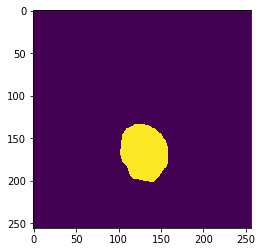

In [27]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('05.U-Net2_results_dir/102_predict.png')
imgplot = plt.imshow(img)
plt.show()

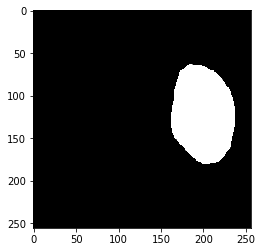

In [28]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray")

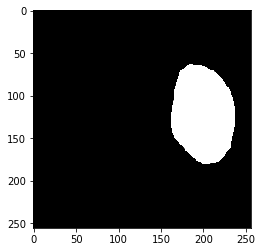

In [29]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray", vmin = 0.0, vmax= 0.09)

[[2.19191716e-04 1.53107887e-10 3.25305926e-15 ... 3.11135102e-12
  5.04867792e-09 1.68627041e-04]
 [4.41433889e-10 4.42851417e-22 4.09696833e-31 ... 2.20362377e-24
  1.94760709e-18 6.11532158e-10]
 [3.34252482e-14 2.37491913e-30 0.00000000e+00 ... 1.26116038e-31
  4.41171487e-24 3.63402722e-13]
 ...
 [1.22308869e-12 7.07996731e-27 0.00000000e+00 ... 0.00000000e+00
  7.17447365e-34 7.14279610e-19]
 [6.85287649e-09 2.11685005e-19 3.59521393e-27 ... 1.67054774e-33
  1.29158902e-25 5.26242292e-14]
 [2.35994798e-04 3.13725240e-10 1.66365741e-14 ... 2.57261236e-18
  1.01132556e-13 5.55746226e-07]]


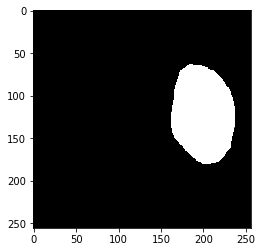

In [30]:
results_ =  np.squeeze(np.multiply(prediction[1], 255))
print(results_)

plt.imshow(results_, cmap = "gray", vmin = 0.0, vmax= 0.7)
plt.show()

Populating the interactive namespace from numpy and matplotlib


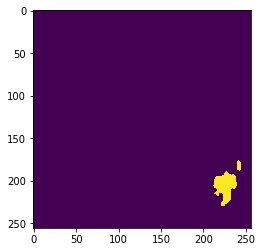

In [31]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('05.U-Net2_results_dir/35_predict.png')
imgplot = plt.imshow(img)
plt.show()

dict_keys(['Jaccard_index', 'val_mean_squared_error', 'loss', 'val_loss', 'val_acc', 'val_precision', 'f1score', 'val_f1score', 'val_Jaccard_index', 'Sensitivity', 'val_recall', 'mean_squared_error', 'precision', 'recall', 'dice_coef', 'val_Specificity', 'Specificity', 'val_dice_coef', 'acc', 'val_Sensitivity'])


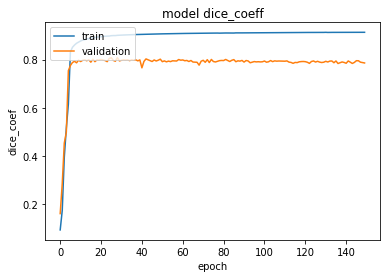

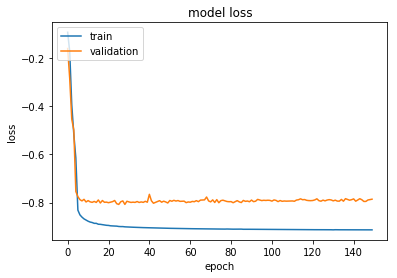

In [32]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()